In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pyspark
from pyspark import sql
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import count, sum, avg, countDistinct, col, when, regexp_extract, regexp_replace, translate
from IPython.display import display
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import data_table
# data_table.enable_dataframe_formatter()
import warnings
warnings.filterwarnings("ignore")

def display(df):
    return df.toPandas().head(20)


spark = SparkSession.builder.master("local[1]").appName("Analytics").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/22 15:53:42 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:

airbnb_df = (
    spark.read.option("header",True).csv('/Users/ashton/Documents/Data_Science_Playground/Kaggle/pyspark_project/Airbnb_Open_Data.csv')
)
display(airbnb_df)

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,...,$193,10,9,10/19/2021,0.21,4,6,286,Clean up and treat the home the way you'd like...,None
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,...,$28,30,45,5/21/2022,0.38,4,2,228,Pet friendly but please confirm with me if the...,None
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,None,Elise,Manhattan,Harlem,40.80902,-73.9419,United States,...,$124,3,0,None,None,5,1,352,"I encourage you to use my kitchen, cooking and...",None
3,1002755,None,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,...,$74,30,270,7/5/2019,4.64,4,1,322,None,None
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,...,$41,10,9,11/19/2018,0.1,3,1,289,"Please no smoking in the house, porch or on th...",None
5,1004098,Large Cozy 1 BR Apartment In Midtown East,45498551794,verified,Michelle,Manhattan,Murray Hill,40.74767,-73.975,United States,...,$115,3,74,6/22/2019,0.59,3,1,374,"No smoking, please, and no drugs.",None
6,1004650,BlissArtsSpace!,61300605564,None,Alberta,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,United States,...,$14,45,49,10/5/2017,0.4,5,1,224,Please no shoes in the house so bring slippers...,None
7,1005202,BlissArtsSpace!,90821839709,unconfirmed,Emma,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,United States,...,$212,45,49,10/5/2017,0.4,5,1,219,House Guidelines for our BnB We are delighted ...,None
8,1005754,Large Furnished Room Near B'way,79384379533,verified,Evelyn,Manhattan,Hell's Kitchen,40.76489,-73.98493,United States,...,$204,2,430,6/24/2019,3.47,3,1,180,- Please clean up after yourself when using th...,None
9,1006307,Cozy Clean Guest Room - Family Apt,75527839483,unconfirmed,Carl,Manhattan,Upper West Side,40.80178,-73.96723,United States,...,$58,2,118,7/21/2017,0.99,5,1,375,NO SMOKING OR PETS ANYWHERE ON THE PROPERTY 1....,None


In [4]:
# shape of the dataset

print(f'{airbnb_df.count()}, {len(airbnb_df.columns)}')

102998, 26


In [5]:
airbnb_df = (
    airbnb_df
    .drop(col('license'))
)

In [6]:
null_values = (
    airbnb_df
    .select(
        [
            F.count(F.when (
                (F.col(c).contains('None')) | (F.col(c).contains('NULL')) | (F.col(c) == "")| (F.col(c).isNull()) | (F.isnan( F.col(c))), c
                )).alias(c)
        for c in airbnb_df.columns
        ]
    )
)
display(null_values)

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,...,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules
0,0,291,401,693,812,430,417,409,411,931,...,648,676,810,608,16289,16251,727,725,1020,52671


In [7]:
# drop null records

airbnb_df = (
    airbnb_df
    .na.drop()
)

In [8]:
# shape of the dataset

print(f'{airbnb_df.count()}, {len(airbnb_df.columns)}')

39504, 25


#### Properties by boroughs

In [9]:
properties_by_borough = (
    airbnb_df
    .groupBy(
        col("neighbourhood group")
    )
    .agg(
        countDistinct("id").alias("cnt_listings")
    )
    .withColumn("sum_of_all_listings", sum(col("cnt_listings")).over(Window.partitionBy()))
    .withColumn("Share of Listings [%]", F.round(100*(col("cnt_listings") / col("sum_of_all_listings")),2))
    .orderBy(
        col("cnt_listings").desc()
    )
    .select(
        "neighbourhood group"
        , "Share of Listings [%]"
    )
)

display(properties_by_borough)

,neighbourhood group,Share of Listings [%]
0,Brooklyn,42.30
1,Manhattan,42.25
2,Queens,12.19
3,Bronx,2.32
4,Staten Island,0.91
5,verified,0.01
6,2,0.01
7,Sidney,0.00
8,Matthew,0.00
9,Carmen,0.00


#### The boroughs Brooklyn and Manhattan received majority (80%) of reviews

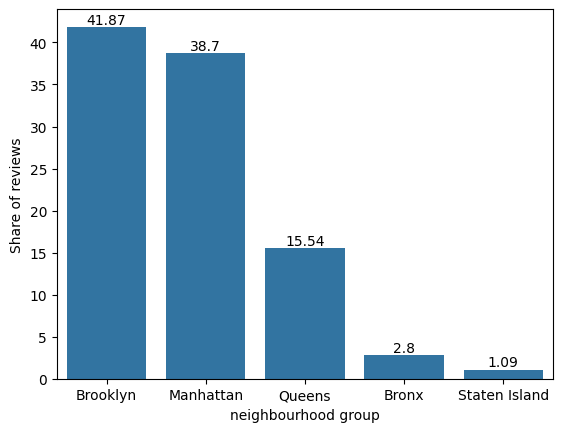

In [10]:
reviews_by_borough = (
    airbnb_df
    .groupBy(
        F.col("neighbourhood group")
    )
    .agg(
        F.avg("number of reviews").alias("avg_reviews")
        ,F.sum("number of reviews").alias("total_reviews")
    )
    .withColumn("sum_of_all_reviews", F.sum(F.col("total_reviews")).over(Window.partitionBy()))
    .withColumn("Share of reviews", F.round(100*(F.col("total_reviews") / F.col("sum_of_all_reviews")),2))
    .filter(
        F.col("total_reviews") > 5000
    )
    .orderBy(
        F.col("total_reviews").desc()
    )
)

vis_1 =  reviews_by_borough.toPandas()

fig_1 = sns.barplot(data=vis_1, x="neighbourhood group", y = "Share of reviews")

for i in fig_1.containers:
    fig_1.bar_label(i,)

In [11]:
# What is the avg price by neighborhood group

avg_price_neighborhood = (
    airbnb_df
    .withColumn("price_new", translate(col('price'), '$,',''))
    .groupby(
        col('neighbourhood group')
    )
    .agg(
        F.mean(col('price_new')).alias('mean price')
    )
    .filter(
        col('mean price') < 1000
    )
    .orderBy(
        col('mean price').desc()
    )
)

display(avg_price_neighborhood)

# vis_2 =  avg_price_neighborhood.toPandas()

# fig_2 = sns.barplot(data=vis_2, x="neighbourhood group", y = "mean price")

# for i in fig_2.containers:
#     fig_2.bar_label(i,)

,neighbourhood group,mean price
0,Queens,623.899210
1,Brooklyn,623.792699
2,Manhattan,623.523461
3,Staten Island,621.659218
4,Bronx,613.238822
5,Long Island City,217.000000
6,Upper East Side,66.000000
7,Elmhurst,49.000000
8,Mott Haven,39.000000
